# Reformatting CHOROS output files
Given the choros output iwasaki_bam.Rda, I want to format it like the data tables generated by iXnos. 
I'll do this using the same train and test genes and constraints that iXnos' preprocessing used. 

`NOTE`: I needed to use R to save iwasaki_bam.Rda as iwasaki_bam.csv first

In [1]:
import pandas as pd
from Bio import SeqIO
import numpy as np
import sys
sys.path.append("scripts/")
# from ixnos import *

df = pd.read_csv("processed-data/choros_iwasaki/outputs/iwasaki_bam.csv").dropna()
# Read in the transcripts file and prune off the UTRs
gdf_path = "iXnos/genome_data/human.transcripts.13cds10.transcripts.fa"
records = list(SeqIO.parse(gdf_path, "fasta"))
gdf = pd.DataFrame({
        'ID': [record.id for record in records],
        'seq': [str(record.seq) for record in records]
    }).set_index("ID")
gdf.loc[:, "seq"] = gdf["seq"].apply(lambda seq: seq[13:-10])
gdf.loc[:, "seq"] = gdf["seq"].apply(lambda seq: [seq[i:i+3] for i in range(0, len(seq), 3)])
gdict = gdf.to_dict()["seq"]

df.head()

,transcript,cod_idx,d5,d3,f5,f3,gc,count,correct_100
0,ENST00000493442.1,102,15,10,TGC,ACT,0.321429,2.000000,2.104242
1,ENST00000234590.7,19,15,10,TCT,TTG,0.428571,16.000000,11.797551
2,ENST00000264258.6,120,15,9,AAA,GAT,0.148148,4.000000,2.689485
3,ENST00000372899.4,844,15,10,AAA,ACT,0.214286,0.277593,0.393276
4,ENST00000372901.1,844,15,10,AAA,ACT,0.214286,0.722407,1.023459


Load in the train and test datasets so I can prune the choros outputs to just those genes.

In [2]:
df_te = pd.read_csv(
    "iXnos/expts/iwasaki/process/te_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep="\t"
)
df_tr = pd.read_csv(
    "iXnos/expts/iwasaki/process/tr_set_bounds.size.27.30.trunc.20.20.min_cts.200.min_cod.100.top.500.data_table.txt",
    sep="\t"
)
genes_tr, genes_te = df_tr["gene"].unique().tolist(), df_te["gene"].unique().tolist()
genes = genes_tr + genes_te
# Subset the choros df to genes in the train or test set
df = df[df["transcript"].isin(genes)]

In [3]:
columns = ["gene", "cod_idx", "cod_seq", "raw_cts", "corrected_cts", "scaled_cts",]
res = pd.DataFrame(columns=columns)
res[["gene", "cod_idx", "corrected_cts", "raw_cts"]] = df[["transcript", "cod_idx", "count", "correct_100"]]
# Sum up rows at the same gene and codon index
res = (
    res
    .groupby(["gene", "cod_idx"], as_index=False)
    .agg(
        {
            "raw_cts": "sum", 
            "corrected_cts": "sum", 
            "scaled_cts": "first", 
            "cod_seq": "first"
            })
    )
res = res[columns]

We need to determine the average counts per codon for each gene:
$$\bar{x} = \frac{1}{L}\sum_{k=1}^{L}{x_k}$$
Where $L$ is the length of the gene, $x_k$ is the choros-corrected scaled counts at that gene

In [4]:
total_cts = res.groupby("gene")["corrected_cts"].sum()
average_cts = {gene : count / len(gdict[gene]) for gene, count in total_cts.items()}
res.loc[:, "scaled_cts"] = res.apply(lambda row: row["corrected_cts"] / average_cts[row["gene"]], axis=1)

In [5]:
# Subtract 1 from codon index, assuming it's 1-based as in R
res["cod_idx"] = res["cod_idx"] - 1
# Considering the truncation of the first and last 20bp, go through each gene and add rows for codon 
# indices with no observations at the A site indicating that 0 counts were observed there
trunc = 20
zero_rows = []
for gene in res["gene"].unique():
    res_gene = res[res["gene"] == gene]
    gene_indices = range(trunc, len(gdict[gene]) - trunc)
    for i in gene_indices:
        if i not in res_gene["cod_idx"].values:
            zero_rows.append({
                "gene": gene,
                "cod_idx": i,
            })
zero_rows_df = pd.DataFrame(zero_rows)
res = pd.concat([res, zero_rows_df])
res[["raw_cts", "corrected_cts"]] = res[["raw_cts", "corrected_cts"]].fillna(0)
# Sort values 
res = res.sort_values(by=["gene", "cod_idx"])
# Fetch codons at codon indices from gdict
res.loc[:, "cod_seq"] = res.apply(lambda row: gdict[row["gene"]][row["cod_idx"]], axis=1)
# Given the truncation, find the min and max codon indices we want for each gene and 
# remove any codon indices outside of that
res.loc[:, "within_bounds"] = res.apply(
    lambda row: 
    (row["cod_idx"] >= trunc) & 
    (row["cod_idx"] < len(gdict[row["gene"]]) - trunc), 
    axis=1)
res = res[res["within_bounds"]].drop("within_bounds", axis=1)
res.loc[:, "scaled_cts"] = res["scaled_cts"].fillna(0)
res.reset_index(drop=True, inplace=True)

/tmp/ipykernel_26214/3846471881.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  res.loc[:, "scaled_cts"] = res["scaled_cts"].fillna(0)


In [6]:
res_tr = res[res["gene"].isin(genes_tr)].copy()
res_te = res[res["gene"].isin(genes_te)].copy()

In [8]:
out_dir = "processed-data/choros_iwasaki"

res_tr.to_csv(f"{out_dir}/tr_ixnos_set_trunc_20_20.data_table.txt", sep="\t", index=False)
res_te.to_csv(f"{out_dir}/te_ixnos_set_trunc_20_20.data_table.txt", sep="\t", index=False)

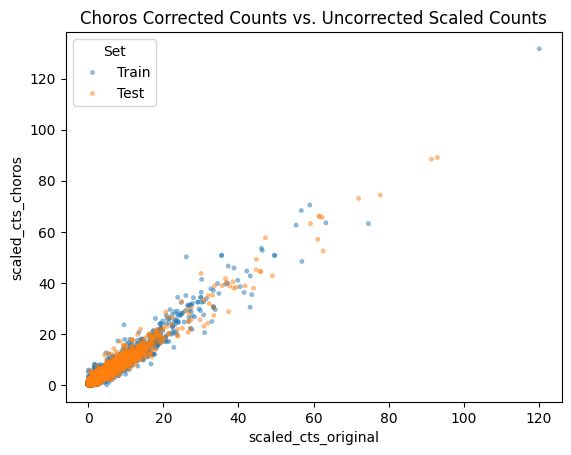

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

tot = pd.merge(left = pd.concat([res_tr, res_te]), right = pd.concat([df_tr, df_te]), how="right", on=['gene', 'cod_idx', 'cod_seq'], suffixes=["_choros", "_original"])
tot.loc[tot["gene"].isin(genes_te), "Set"] = "Test"
tot.loc[tot["gene"].isin(genes_tr), "Set"] = "Train"

sns.scatterplot(tot, 
    x='scaled_cts_original',
    y='scaled_cts_choros', 
    hue="Set",
    s=10, alpha=0.5, edgecolor=None, 
)
plt.title("Choros Corrected Counts vs. Uncorrected Scaled Counts")
plt.show()

,gene,cod_idx,cod_seq,raw_cts,scaled_cts
0,ENST00000022615.7,20,GGA,0.000000,0.000000
1,ENST00000022615.7,21,TAT,2.000000,0.347707
2,ENST00000022615.7,22,GGC,2.000000,0.347707
3,ENST00000022615.7,23,TTT,2.000000,0.347707
4,ENST00000022615.7,24,GGC,0.000000,0.000000
...,...,...,...,...,...
49129,ENST00000618183.3,237,GAG,9.398850,0.601385
49130,ENST00000618183.3,238,GAA,3.916010,0.250566
49131,ENST00000618183.3,239,ATT,4.699496,0.300697
49132,ENST00000618183.3,240,ATG,3.133092,0.200471
